# dag

> Execution DAGs

In [1]:
# | default_exp dag

In [2]:
# | hide
%load_ext autoreload
%autoreload 2

In [3]:
# | hide
from nbdev.showdoc import *

In [4]:
# | export
from typing import Any, Callable, List, Optional, TypeVar
import networkx as nx
from pydantic import BaseModel

In [5]:
# | export

class Node:
    def __init__(
        self,
        id: str,
        runFn: Callable[any, any],
        deps: Optional[List[str]] = None,
        input_schema: Optional[BaseModel] = None,
        output_schema: Optional[BaseModel] = None,
        input_hook: Optional[Callable[BaseModel, BaseModel]] = None,
        output_hook: Optional[Callable[BaseModel, BaseModel]] = None,
    ):
        self.id = id
        self.runFn = runFn
        self.deps = deps or []
        self.input_schema = input_schema
        self.output_schema = output_schema
        self.input_hook = input_hook
        self.output_hook = output_hook

    def run(self, input, check: bool = True):
        if check and self.input_schema:
            self.input_schema.model_validate(input)

        if self.input_hook:
            input = self.input_hook(input)

        result = self.runFn(input)

        if self.output_hook:
            result = self.output_hook(result)

        if check and self.output_schema:
            self.output_schema.model_validate(result)

        return result

In [6]:
#| hide

runFn = lambda x: x * 2
node = Node(id="node1", runFn=runFn)
node.run(2)

4

In [7]:
# | export

class DAG:
    def __init__(self, nodes: List[Node]):
        graph = nx.DiGraph()

        for node in nodes:
            graph.add_node(node.id, node=node)

            if node.deps:
                for dep in node.deps:
                    graph.add_edge(dep, node.id)

        self.graph = graph
        self.reset()

    def reset(self):
        self.intermediate_results = {}
        self.results = {}

    def run(self, input_, check: bool = False, debug: bool = False):
        print(f"INPUT FN {input_}")
        sorted_graph = nx.topological_sort(self.graph)
    
        for node_id in sorted_graph:
            print(f"NODE {node_id}")
            node = self.graph.nodes[node_id]["node"]

            if self.graph.in_degree(node_id) == 0:
                dep_results = {"input": input_}
                print(f"INPUT1 {dep_results}")
            else:
                dep_results = {
                    dep: self.intermediate_results[dep]
                    for dep in self.graph.predecessors(node_id)
                }
                print(f"INPUT2 {dep_results}")

            # print(f"INPUT {dep_results}")
            result = node.run(input, check)
            print(f"RESULT {result}")

            if self.graph.out_degree(node_id) == 0:
                self.results[node_id] = result
            else:       
                self.intermediate_results[node_id] = result

        return self.results

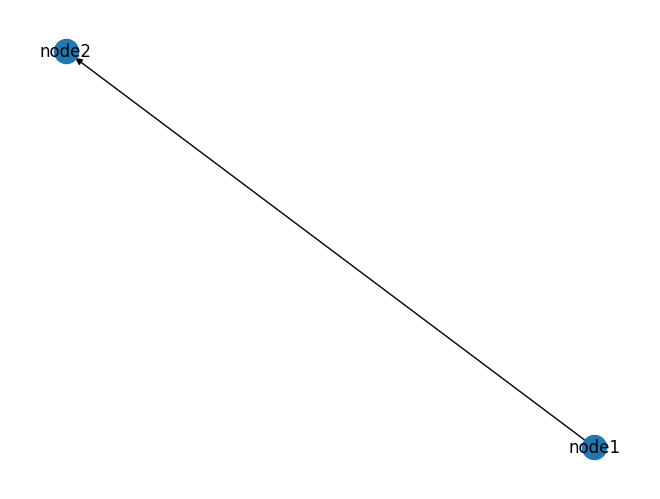

In [10]:
#| hide
    
runFn1 = lambda x: x["input"] * 2
node1 = Node(id="node1", runFn=runFn1)

runFn2 = lambda x: x["node1"] + 1
node2 = Node(id="node2", runFn=runFn2, deps=["node1"])

dag = DAG(nodes=[node1, node2])
nx.draw(dag.graph, with_labels=True)

In [11]:
#| hide

dag.run(1)

INPUT FN 1
NODE node1
INPUT1 {'input': 1}


TypeError: 'method' object is not subscriptable

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()